# Import Libraries

In [1]:
import time as t
import matplotlib.pyplot as plt
from sage.misc.sage_timeit import sage_timeit

# Main Functions

In [2]:
def trouver_mu(c_values, n_values, e):
    """
    Trouve la valeur de 'mu' en utilisant le Théorème des Restes Chinois et la racine e-ème.
    
    :param c_values: List[int], Liste des valeurs de 'c' (chiffrées) dans le cadre du RSA.
    :param n_values: List[int], Liste des modules 'n' correspondant à chaque valeur de 'c'.
    :param e: int, L'exposant utilisé dans le chiffrement RSA (doit être commun à toutes les paires (c, n)).
    
    :return: int, La valeur de 'mu' obtenue après déchiffrement et extraction de la racine e-ème.
    
    Utilise le Théorème des Restes Chinois pour trouver 'x' à partir des valeurs 'c_values' et 'n_values'.
    Calcule ensuite la racine e-ème de 'x' pour obtenir 'mu', en supposant que 'x' est une puissance parfaite de 'e'.
    """
    # Utilisation du Théorème des Restes Chinois pour trouver x
    x = crt(c_values, n_values)

    # Calcul de la racine e-ème de x (x est une puissance parfaite de e)
    mu = x.nth_root(e)
    
    return mu

In [3]:
def newton_method_e_root(x, e, tolerance=1e-10, max_iterations=100):
    """
    Utilise la méthode de Newton pour calculer la racine e-ème d'un nombre 'x'.

    :param x: float, Le nombre dont on cherche la racine e-ème.
    :param e: int, Le degré de la racine.
    :param tolerance: float, Le seuil de tolérance pour l'arrêt de l'algorithme (valeur par défaut : 1e-10).
    :param max_iterations: int, Le nombre maximum d'itérations avant l'arrêt de l'algorithme (valeur par défaut : 100).
    
    :return: tuple, Retourne un tuple contenant la valeur approchée de la racine, le nombre d'itérations effectuées et l'historique des valeurs de 'y' à chaque itération.

    Lève une erreur si 'x' est négatif et 'e' est pair, car une racine paire d'un nombre négatif n'est pas définie.
    Utilise une approche itérative pour se rapprocher progressivement de la racine e-ème. La méthode s'arrête lorsque la différence entre deux itérations successives est inférieure à la tolérance ou lorsque le nombre maximum d'itérations est atteint.
    """
    if x < 0 and e % 2 == 0:
        raise ValueError("Negative number cannot have an even root")

    y = x
    iterations = 0  # Compteur d'itérations
    history = []  # Pour suivre l'évolution de y à chaque itération

    for _ in range(max_iterations):
        y_prev = y
        y = y - (y**e - x) / (e * y**(e-1))
        history.append(y)
        iterations += 1  # Incrémenter le compteur

        # Vérifier la convergence
        if abs(y - y_prev) < tolerance:
            break

    return y, iterations, history  # Retourner la valeur approchée, le nombre d'itérations et l'historique

In [4]:
def newton_method_e_root_with_ini(x, e, initial_guess=None, tolerance=1e-10, max_iterations=100):
    if x < 0 and e % 2 == 0:
        raise ValueError("Negative number cannot have an even root")

    if initial_guess is None:
        y = x / 2  # Choix d'une valeur initiale par défaut
    else:
        y = initial_guess

    iterations = 0
    history = []

    for _ in range(max_iterations):
        y_prev = y
        y = y - (y**e - x) / (e * y**(e-1))
        history.append(y)
        iterations += 1

        if abs(y - y_prev) < tolerance:
            break

    return y, iterations, history

In [7]:
# Methode d'exponentiation modulaire rapide

def modular_exponentiation(M, e, n):
    """
    Effectue l'exponentiation modulaire rapide de 'M' à la puissance 'e' modulo 'n'.
    
    :param M: int, La base de l'exponentiation.
    :param e: int, L'exposant pour l'opération d'exponentiation.
    :param n: int, Le modulo pour l'exponentiation.
    
    :return: int, Le résultat de M^e mod n calculé en utilisant l'exponentiation modulaire rapide.
    
    Utilise la décomposition binaire de l'exposant pour effectuer l'exponentiation de manière efficace.
    """
    # Initialisation
    R = 1

    # Décomposition Binaire de l'Exposant
    binary_e = bin(e)[2:]

    # Itération sur Chaque Bit de l'Exposant
    for bit in binary_e:
        R = (R * R) % n  # Toujours effectuer un carré
        if bit == '1':
            R = (R * M) % n  # Multiplier si le bit courant est 1

    return R

def find_suitable_e_values(phi_n, min_value, max_value):
    """
    Trouve les valeurs de 'e' appropriées pour le chiffrement RSA dans une plage donnée.

    :param phi_n: int, La valeur de φ(n) pour laquelle 'e' doit être premier.
    :param min_value: int, La valeur minimale à partir de laquelle chercher.
    :param max_value: int, La valeur maximale jusqu'à laquelle chercher.
    
    :return: List[int], Une liste des valeurs 'e' qui sont premières par rapport à 'φ(n)'.
    
    Parcourt seulement les nombres impairs car 'e' doit être impair dans RSA.
    """
    suitable_e_values = []
    for e in range(min_value, max_value, 2):  # Parcourir seulement les nombres impairs
        if gcd(e, phi_n) == 1:
            suitable_e_values.append(e)
    return suitable_e_values

In [6]:
def generate_e_values_prime_with_phi(length, phi):
    """
    Génère des valeurs de 'e' avec une longueur binaire spécifique, premières par rapport à 'phi', 
    et seulement un exemple par nombre de 1s dans la représentation binaire.

    :param length: int, La longueur binaire des nombres 'e' à générer.
    :param phi: int, La valeur de 'phi' par rapport à laquelle 'e' doit être premier.

    :return: List[int], Liste des valeurs 'e' qui respectent les critères spécifiés.

    Parcourt tous les nombres possibles ayant la longueur binaire spécifiée. Pour chaque nombre, 
    il vérifie s'il est premier par rapport à 'phi' et s'il a un nombre unique de 1s dans sa représentation binaire.
    """
    e_values = []
    seen_ones_count = set()  # A set to keep track of the count of 1's we've seen
    
    # Iterate over all possible binary numbers of the given length
    start = 2**(length - 1)  # Smallest number with 'length' bits
    end = 2**length          # One past the largest number with 'length' bits

    for e in range(start, end):
        ones_count = bin(e).count('1')
        # Check if we have already seen this count of 1's
        if ones_count in seen_ones_count:
            continue  # Skip this number if we have

        # Check if e is prime relative to phi
        if gcd(e, phi) == 1:
            e_values.append(e)
            seen_ones_count.add(ones_count)  # Mark this count of 1's as seen

    return e_values

# Needed cte

In [3]:
# Initialisation des paramètres pour le chiffrement RSA
e = 3         # L'exposant public utilisé dans le chiffrement RSA
mu = 36       # Le message à chiffrer
r = 15        # Le nombre de premiers différents à générer (e < r)
n = 1         # Initialisation du module RSA
phi_n = 1     # Initialisation de φ(n), utilisé pour calculer l'exposant privé dans RSA

# Génération du premier nombre premier et du premier chiffré
N = [next_prime(2^30)]   # Génère le premier nombre premier supérieur à 2^30
C = [ZZ(Zmod(N[0])(mu^e))]  # Calcule le premier chiffré C[0] = mu^e mod N[0]

# Boucle pour générer les 'r' premiers et leurs chiffrés correspondants
for i in range(1, r):
    next_p = next_prime(N[i-1])   # Génère le prochain nombre premier
    N.append(next_p)              # Ajoute ce nombre premier à la liste N
    C.append(ZZ(Zmod(N[i])(mu^e))) # Calcule le chiffré C[i] = mu^e mod N[i]

# Calcul du module RSA et de φ(n) pour le chiffrement RSA
for i in range(0, r):
    n *= N[i]            # Multiplie tous les nombres premiers pour obtenir 'n'
    phi_n *= (N[i] - 1)  # Calcule φ(n) comme le produit de (N[i]-1) pour chaque premier N[i]

# Part 1:

### Proposition 1:
    Si µ < min16i6r ni (c’est l’hypothèse que l’on a fait à l’origine sur l’encodage du message), et si e 6 r , on peut retrouver µ à partir de c1,...,cr en effectuant un nombre d’opérations polynomial en log(n)

In [ ]:
# Mesure et affiche le temps nécessaire pour exécuter la fonction `trouver_mu`
exe_t = sage_timeit('trouver_mu(C, N, e)', globals(), preparse=True, number=50)
exe_t = mean(exe_t.series) 

print(f'▶️ mu = {trouver_mu(C, N, e)} with an execution time = {exe_t}')

### Méthode de calcul de la racine e-ième d’un nombre:
    Calcul de complexité binaire 

In [9]:
# Exécuter la fonction pour x = 8 et e = 3 (racine cubique)
racine, iterations, history = newton_method_e_root(8, 3)
racine  #L'algorithme n'a pas pu converger après 100 itération ca mauvaise initialisation

# Exécute la fonction newton_method_e_root pour calculer la racine cubique de 8
racine, iterations, history = newton_method_e_root(8, 3)

# Affiche la valeur de la racine calculée
racine  # Doit afficher le résultat de la racine cubique de 8

# Note:l'algorithme n'ait pas convergé après 100 itérations, ce qui pourrait être dû à une mauvaise initialisation.
# Donc il faut soit ajuster la valeur de départ ou d'augmenter le nombre maximal d'itérations.


6253664248705734605417247929693971831365277952038691253591022486416499589402078172103265858784855850890709697136457504387592906697286117208587117832941971294503098012603325798556932744560181656096650364729660090193979089646997421675536519548811862920819974147919769294171008750472237488112480501670066263556489564113614078381493214539613931475633958478703680883148170850026832862442152287287458249763849327820480600028779811717395716892408784807720049024759934683248520153895455449344574012178734889651184387306523185752257934165473829625164074344230825059645727453998813067073985731507796821574827824866433444659792511987553926226424855067407239906119051211385694403756681749177901204861752587649702333425842923354221851443623131653269494427714602682747446145085822398220458214744991912585451676017332663742688152547339845711414341126727281151842356371529040003368818257171302291713531399092907689442595306264836240610994983867187427824293659823737397960955291413194701699249837673252053157808429940

In [15]:
initial_guesses = [1.0, 2.0, 5.0, 10.0]  # Ensemble des estimations initiales à tester

for guess in initial_guesses:
    print(f"▶️Test avec une estimation initiale de {guess}:")
    racine, iterations, history = newton_method_e_root_with_ini(8, 3, initial_guess=guess)
    print(f'''  ✅Racine: {racine}
  ✅Iterations: {iterations}
  ✅Premières valeurs de l'historique: {history[:10]}
''')

▶️Test avec une estimation initiale de 1.00000000000000:
  ✅Racine: 2.00000000000000
  ✅Iterations: 7
  ✅Premières valeurs de l'historique: [3.33333333333333, 2.46222222222222, 2.08134124767158, 2.00313749914129, 2.00000491167550, 2.00000000001206, 2.00000000000000]

▶️Test avec une estimation initiale de 2.00000000000000:
  ✅Racine: 2.00000000000000
  ✅Iterations: 1
  ✅Premières valeurs de l'historique: [2.00000000000000]

▶️Test avec une estimation initiale de 5.00000000000000:
  ✅Racine: 2.00000000000000
  ✅Iterations: 7
  ✅Premières valeurs de l'historique: [3.44000000000000, 2.51868036776636, 2.09948144044716, 2.00463935741311, 2.00001072862957, 2.00000000005755, 2.00000000000000]

▶️Test avec une estimation initiale de 10.0000000000000:
  ✅Racine: 2.00000000000000
  ✅Iterations: 9
  ✅Premières valeurs de l'historique: [6.69333333333333, 4.52174508693865, 3.14492044412661, 2.36623195347484, 2.05375893006348, 2.00139490873692, 2.00000097198126, 2.00000000000047, 2.00000000000000]



In [ ]:
##I need to add dakchi lisift lia oumar

In [6]:
exe_time = sage_timeit('modular_exponentiation(mu, e, n)', globals(), preparse=True, number=50) 
exe_time = mean(exe_time.series)

print(f'▶️ we got mu**e: {modular_exponentiation(mu, e, n)} with an execution time of:{exe_time}')

▶️ we got mu**e: 46656 with an execution time of:4.096000047866256e-06


###  Cout du chiffrement en fonction de log(n) = log(pq) :

In [8]:
c1 = []
mu = 10**40
e = next_prime(10**30) # on fixe e
for i in range(30,100): # boucle pour générer n = pq

    p = next_prime(10**i)
    q = next_prime((10**(i+1)))

    n = p*q

    phi_n = (p-1)*(q-1)

    execution_time = sage_timeit('modular_exponentiation(mu,e,n)', globals(), preparse=True, number=50)
    execution_time = mean(execution_time.series)

    c1.append((log(n).n(),execution_time))

# générer p,q de l'ordre de 10**i, 10**(i+1) respectivement

x_1 = [item[0] for item in c1] # log(n)
y_1 = [item[1] for item in c1] # execution_time

# Courbe 1: execution_time en fonction de la Longueur de n=pq :
plt.figure(1)

plt.scatter(x_1, y_1, marker='o')

plt.xlabel('Longueur de n')
plt.ylabel('Temps de chiffrement')

plt.title('execution_time en fonction de la longueur de n')
plt.grid(True)

plt.show()

/opt/sagemath-9.3/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:7: RuntimeWarning: cypari2 leaked 377944 bytes on the PARI stack


KeyboardInterrupt: 

### Pouquoi e = 3, 257, 65537

In [ ]:
# Initialisation d'une liste vide pour stocker les résultats
res = []

# Boucle sur une série de valeurs 'e' appropriées pour RSA, de 1 à 65539
for e in find_suitable_e_values(phi_n, 1, 10**20):
    bits_count = bin(e).count('1')  # Compte le nombre de bits à 1 dans la représentation binaire de 'e'
    # Mesure le temps d'exécution de l'exponentiation modulaire pour chaque valeur de 'e'
    execution_time = sage_timeit('modular_exponentiation(mu, e, n)', globals(), preparse=True, number=50) 
    execution_time = mean(execution_time.series)  # Calcul de la moyenne des temps d'exécution
    # Ajout de la valeur de 'e', du temps d'exécution moyen et du nombre de bits à 1 dans la liste 'res'
    res.append((e, execution_time, bits_count))
    
# Note: Ce code vise à analyser l'impact de la longueur de 'e' (mesurée par le nombre de bits à 1 dans sa représentation binaire)
# sur le temps d'exécution de l'exponentiation modulaire. Cela permet de comprendre comment la complexité de 'e'
# influence la performance de l'algorithme de chiffrement RSA. 

In [ ]:
# Extraction des données pour le graphique
x_1, y_1 = [item[0] for item in res], [item[1] for item in res]  # Séparation des valeurs de 'e' et des temps d'exécution

# Création du graphique
plt.scatter(x_1, y_1, marker='o')
plt.xlabel('longueur de e')
plt.ylabel('Temps d\'encodage')
plt.title('Graphique de e en fct de temps d\'encodage')
plt.grid(True)
plt.show()

In [63]:
time_taken = []
one_count = []
res = []

e_val = generate_e_values_prime_with_phi(34, phi_n)

for e in e_val:
    one_count.append(bin(e).count('1'))
    time_tak = sage_timeit('modular_exponentiation(mu, e, n)', globals(), preparse=True, number=50) 
    time_taken.append(mean(time_tak.series))
    res.append([e, bin(e).count('1'), mean(time_tak.series)])

# print('time_taken:', time_taken, 'e_val:', e_val, 'one_count:', one_count)
# print(f'tt, e_val, one_count: {res}')

tt, e_val, one_count: [[8589934601, 3, 1.8923333069930473e-05], [8589934607, 5, 1.8993999886636934e-05], [8589934627, 4, 2.0983333233743905e-05], [8589934651, 6, 1.935799955390394e-05], [8589934687, 7, 1.9596666485692065e-05], [8589934783, 8, 2.000999986194074e-05], [8589935071, 9, 2.0059333182871343e-05], [8589935999, 10, 2.4772000033408405e-05], [8589936127, 11, 2.078933292068541e-05], [8589937663, 12, 2.1240666198233765e-05], [8589942271, 13, 2.1468666770185036e-05], [8589950911, 14, 2.374599998195966e-05], [8589959167, 15, 2.194666652940214e-05], [8589996031, 16, 2.1683333131174246e-05], [8590000127, 17, 2.1806666627526283e-05], [8590180351, 18, 2.165733332124849e-05], [8590327807, 19, 2.3007999795178574e-05], [8590721023, 20, 2.2978666626537838e-05], [8591900671, 21, 2.33453333688279e-05], [8593080319, 22, 2.3855332983657718e-05], [8596226047, 23, 2.871466684155166e-05], [8602517503, 24, 2.4167333419124288e-05], [8606711807, 25, 2.4258666671812533e-05], [8652849151, 26, 2.47113332

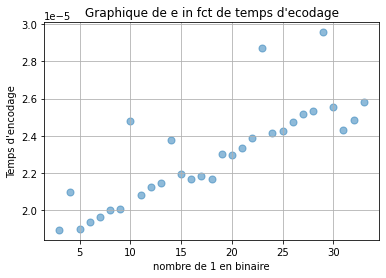

In [64]:
x, y = [item[1] for item in res], [item[2] for item in res]

plt.scatter(x, y, s=50, alpha=0.5)  # s is the size, alpha is the transparency level
plt.xlabel('nombre de 1 en binaire')
plt.ylabel('Temps d\'encodage')
plt.title('Graphique de e in fct de temps d\'ecodage')
plt.grid(True)
plt.show()